**Log in to CATMAID instance**
<br>
After importing pymaid and contools, you must log in to your CATMAID instance. You will need to provide your username, password, token, and the url of the CATMAID instance.
Here, these data are stored in pymaid_creds.py and imported into the script. Make sure to add this filename to a .gitignore file to prevent sharing your credentials on github.

In [2]:

import pymaid
import contools

from data_settings import data_date, pairs_path # path information for example dataset
from pymaid_creds import url, name, password, token
rm = pymaid.CatmaidInstance(url, token, name, password)

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


**Signal Cascade Algorithm**
<br>
Signal cascades simulate multihop signal propagation through a network.
This propagation is probabilistic, but determined by the edge weight (synaptic strength in biological neural networks).

$P(propagation) = 1-(1-p)^n$ , where $n = \sum_{}^{}$ upstream actived synapses
<br>

These propagation calculations are run for each neuron in the network iteratively per hop until the signal has run through the whole network.
Note that when run with $simultaneous=True$, the synaptic strength from multiple upstream neurons is combined to calculate the chance that a downstream neuron is activated.

**Parameter Setup**
- *name*: a string which is the name of the cascade, for logging purposes only

+ *source_skids*: an array [] of CATMAID skeleton IDs, which indicate the starting point(s) of the cascade

- *stop_skids*: an array [] of CATMAID skeleton IDs, which indicate the end point(s) of the cascade. When signal reaches an end point, that portion of the cascade stops

+ *adj*: pandas DataFrame of the adjacency matrix of the network, with skeleton IDs for row and column names

- *p*: probability of propagating signal per individual synapse, suggested value = 0.05

+ *max_hops*: the max number of hops the cascade will run

- *n_init*: the number of iterations. because cascades are probabilistic, multiple cascades will be run and their results summed

+ *simultaneous*: True or False. Determines whether neurons that are simultaneously active can sum their outputs to more effectively activate their shared downstream partners


In [3]:
name = 'CN-4 cascade' 
source_skids = pymaid.get_skids_by_annotation('CN-4')
stop_skids = pymaid.get_skids_by_annotation('mw dVNC')
adj = contools.Promat.pull_adj(type_adj='ad', date=data_date, subgraph=['mw brain paper clustered neurons', 'mw brain accessory neurons']) # can also load and use a CSV instead
p = 0.05
max_hops = 10
n_init = 100
simultaneous = True

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


Fetching:   0%|          | 0/2 [00:00<?, ?it/s]

Not all skids are in adjacency matrix!
Check: [38147, 5434746, 5435750, 5437704, 5452286, 8127911, 8134938, 8193545, 8199012, 10316044, 10358617, 12989453, 15542199, 15609427, 17519626, 17729029, 17732426]


**Running the Cascade**
<br>
Assemble the previously defined variables and input into the appropriate function contools.Cascade_Analyzer.run_single_cascade()

In [7]:

cascade = contools.Cascade_Analyzer.run_single_cascade(
    name = name,
    source_skids = source_skids,
    stop_skids = stop_skids,
    adj = adj,
    p = p,
    max_hops = max_hops,
    n_init = n_init,
    simultaneous = simultaneous
)

100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


**Sorting Data and Plotting**
<br>
The cascade is output as a Cascade_Analyzer() object. The raw data is stored in cascade.skid_hit_hist, which is a pandas Dataframe where rows = skeleton IDs and columns = number of hops. 0 hops indicates the user-defined activated neurons. The data itself indicates number of visits across all cascade iterations, such than a neuron with 25 visits was visited in 25/100 cascades.

The data can be sorted using pandas pd.sort_values() and displayed in its raw format. This sorted data is then displayed with a simple heatmap, where rows indicate individual neurons and columns indicate hops from cascade origin. The color scale represents number of visits per hop.

In [4]:
data = cascade.skid_hit_hist
data_sorted = data.sort_values(by = list(data.columns), ascending=False)
data_sorted

,0,1,2,3,4,5,6,7,8,9,10
10543751,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11464638,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4022539,0.0,55.0,7.0,24.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0
14083681,0.0,54.0,7.0,15.0,19.0,5.0,0.0,0.0,0.0,0.0,0.0
7980189,0.0,50.0,8.0,27.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19180425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19470184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19718010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20316708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

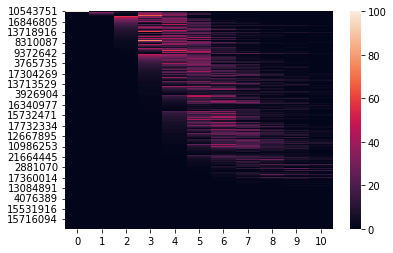

In [5]:
import seaborn as sns

sns.heatmap(data_sorted)